In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
Data=pd.read_excel('/content/drive/MyDrive/Labelled Reddit Data.xlsx')

In [3]:
from imblearn.over_sampling import RandomOverSampler
X = Data['Lemma']
y = Data['Manual Label']
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)
oversampled_data = pd.DataFrame({'text': X_resampled.ravel(), 'manual_label': y_resampled})

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.ravel())
X_val_vec = vectorizer.transform(X_val.ravel())

In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [7]:
rf = RandomForestClassifier(n_estimators=700,min_samples_split= 2, random_state=42,class_weight='balanced')
svm = SVC(kernel='poly', C=10, gamma='scale', random_state=42,class_weight='balanced')
gb = GradientBoostingClassifier(learning_rate= 1, max_depth= 5, n_estimators= 700)
nb = MultinomialNB(alpha = 0.01, fit_prior= True)
dt = DecisionTreeClassifier(max_depth= 8, min_samples_leaf= 3, min_samples_split= 2,class_weight='balanced')
#eec = EasyEnsembleClassifier(n_estimators=700, random_state=42)

In [8]:
from sklearn.ensemble import  VotingClassifier
ensemble = VotingClassifier([('rf', rf), ('svm', svm),('gb',gb),('nb',nb),('dt',dt)], voting='hard')
ensemble.fit(X_train_vec, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=700,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=10, class_weight='balanced', kernel='poly',
                                  random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=1,
                                                         max_depth=5,
                                                         n_estimators=700)),
                             ('nb', MultinomialNB(alpha=0.01)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=8,
                                                     min_samples_leaf=3))])

In [9]:
from sklearn.metrics import classification_report
ensemble_preds = ensemble.predict(X_val_vec)
print(classification_report(y_val, ensemble_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       1.00      0.98      0.99       508

    accuracy                           0.99       980
   macro avg       0.99      0.99      0.99       980
weighted avg       0.99      0.99      0.99       980



In [ ]:
#from imblearn.ensemble import EasyEnsembleClassifier

#eec = EasyEnsembleClassifier(n_estimators=5, random_state=42)
#eec.fit(X_train_vec, y_train)
#ensemble_preds = eec.predict(X_val_vec)
#print(classification_report(y_val, ensemble_preds))


In [10]:
Data2=pd.read_excel('/content/drive/MyDrive/FYP VIVA Presentation/unlabelled data2.xlsx')

In [11]:
X_test = Data2['Lemma']
X_test_transformed = vectorizer.transform(X_test)
y_pred_test = ensemble.predict(X_test_transformed)

In [12]:
y_true=Data2['clusters']

In [13]:
print(classification_report(y_true, y_pred_test))

              precision    recall  f1-score   support

           0       0.44      0.08      0.13       880
           1       0.87      0.99      0.93      5765

    accuracy                           0.87      6645
   macro avg       0.66      0.53      0.53      6645
weighted avg       0.82      0.87      0.82      6645



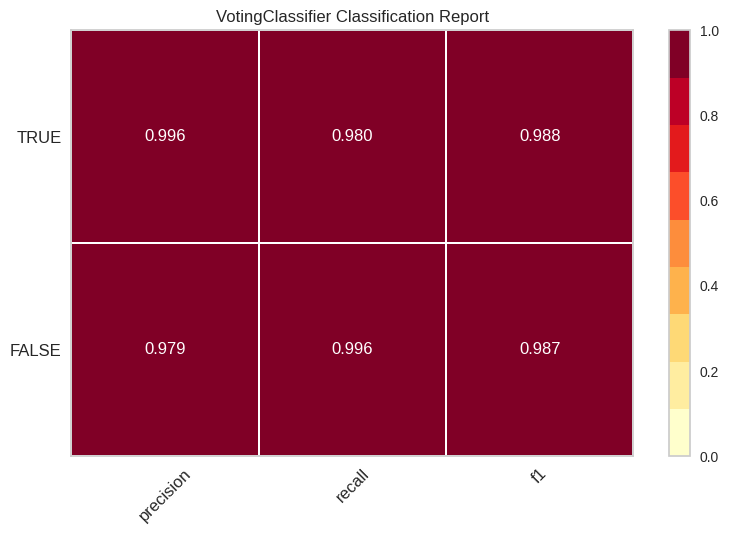

<Axes: title={'center': 'VotingClassifier Classification Report'}>

In [14]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(ensemble, classes=['FALSE', 'TRUE'])
visualizer.fit(X_train_vec, y_train)
visualizer.score(X_val_vec, y_val)
visualizer.show()


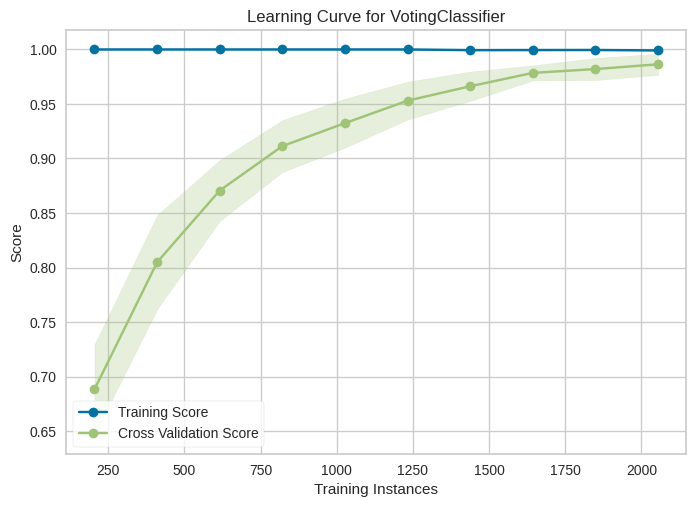

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [15]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

lc_viz = LearningCurve(
    ensemble, cv=cv, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

lc_viz.fit(X_train_vec, y_train)
lc_viz.show()

In [17]:
# select a random text from Data2
import random
text_index = random.randint(0, len(Data2) - 1)
text_sample = X_test[text_index]

# vectorize the text sample
text_sample_transformed = vectorizer.transform([text_sample])

# predict the label of the text sample
label_predicted = ensemble.predict(text_sample_transformed)[0]

# print the result
if label_predicted == 1:
    print('The text is classified as TRUE')
else:
    print('The text is classified as FALSE')

The text is classified as TRUE


In [20]:
import random

# Select a random row index from Data2
random_index = random.randint(0, len(Data2)-1)

# Get the text from the randomly selected row
text = Data2.iloc[random_index]['Lemma']

# Transform the text using the vectorizer
text_transformed = vectorizer.transform([text])

# Use the model to predict the label of the text
label_pred = ensemble.predict(text_transformed)

# Print the text and predicted label
print("Text: ", text)
if label_pred == 1:
    print('The text is classified as TRUE')
else:
    print('The text is classified as FALSE')
#print("Predicted Label: ", label_pred[0])

Text:    Clearly neither mod people give  quality sub dog
The text is classified as TRUE


In [ ]:
from sklearn.model_selection import GridSearchCV


rf_params = {'n_estimators': [100, 200, 300,400,500],
             'max_depth': [None, 5, 10,15,20],
             'min_samples_split': [2, 5, 10,15,20]}

svm_params = {'C': [1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

gb_params = {'n_estimators': [100, 200, 300,400,500],
             'learning_rate': [0.01, 0.1, 1],
             'max_depth': [3, 5, 10]}

nb_params = {'alpha': [0.01, 0.1, 1.0, 10.0],
             'fit_prior': [True, False]}

dt_params = {'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 2, 3, 4]}

In [ ]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5,n_jobs=1)
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=5,n_jobs=1)
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5,n_jobs=1)
nb_grid = GridSearchCV(nb, nb_params, cv=5,n_jobs=1)
dt_grid = GridSearchCV(dt, dt_params, cv=5,n_jobs=1)

In [ ]:
rf_grid.fit(X_train_vec, y_train)
svm_grid.fit(X_train_vec, y_train)
gb_grid.fit(X_train_vec, y_train)
nb_grid.fit(X_train_vec, y_train)
dt_grid.fit(X_train_vec, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=8, min_samples_leaf=3),
             n_jobs=1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8]})

In [ ]:
print("Random forest best params:", rf_grid.best_params_)
print("SVM best params:", svm_grid.best_params_)
print("Gradient boosting best params:", gb_grid.best_params_)
print("Naive best params:", nb_grid.best_params_)
print("Decision tree best params:", dt_grid.best_params_)

Random forest best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}
SVM best params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Gradient boosting best params: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 500}
Naive best params: {'alpha': 0.01, 'fit_prior': False}
Decision tree best params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
